![banner](https://anopheles-genomic-surveillance.github.io/_images/banner.jpg)

***Training course in data analysis for genomic surveillance of African malaria vectors - Workshop 5***

---

# Module 1 - Xarray datasets

**Theme: Tools & technology**

This module introduces [xarray](https://docs.xarray.dev/en/stable/), a Python package for working with scientific datasets, including datasets comprising multidimensional arrays with shared and labelled dimensions. Like other general-purpose scientific computing packages like NumPy and pandas, xarray is very useful for genomic data, but it is also used in a variety of other scientific fields. 

This module is intended to provide a gentle introduction to xarray for scientists and analysts coming from a malaria or genetics background. Please note that there is an excellent [xarray tutorial website](https://tutorial.xarray.dev/intro.html) and [xarray YouTube channel](https://www.youtube.com/channel/UCBlxVSA6xQXeb-i4GgTlO7g) with much more information on what xarray can do and how to use it, that you might like to visit after completing this tutorial. 

## Learning objectives

At the end of this module you will be able to:

* Explain why xarray is useful for scientific computing
* Explain what an xarray Dataset is
* Access variables (arrays) in a dataset
* Use indexing to select data within a dataset
* Review how we use xarray for genomic data


## Lecture

### English

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/5N7-Tg3_M-8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Français

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/kuSnW0XqbZg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Setup

Install and import the packages we'll need.

In [3]:
!pip install -q malariagen_data rioxarray

In [4]:
import malariagen_data
import xarray as xr
import numpy as np
# configure plotting with matplotlib
%matplotlib inline
%config InlineBackend.figure_format = "retina"

Configure access to the MalariaGEN Ag3 data resource.

In [5]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0
Results cache           : None
Cohorts analysis        : 20220608
Species analysis        : aim_20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 6.0.0
Client location         : Iowa, US (Google Cloud)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

## Introduction

### Recap: multidimensional arrays

Previously in [workshop 4, module 1](../workshop-4/module-1-numpy) we introduced the concept of multidimensional arrays, and how they can be used to store some different types of scientific data. Let's recap two examples.

The first example is a grayscale image, which can be stored as a 2-dimensional array of numbers. Each element in the array represents a pixel, and the value of the number encodes the colour. One dimension of the array corresponds to the vertical position of the pixels within the image, and the other dimension of the array corresponds to the horizontal position of the pixels.

<img src="https://jalammar.github.io/images/numpy/numpy-grayscale-image.png" width="700"/>

The second example is a set of genotype calls obtained from sequencing some mosquitoes. These data can be stored as a 3-dimensional array, where one dimension of the array corresponds to positions (sites) within a reference genome, another dimension corresponds to the individual mosquitoes that were sequenced, and a third dimension corresponds to the number of genomes within each individual (mosquitoes are diploid, hence this dimension has length 2).

<img src="https://storage.googleapis.com/vo_agam_release/reference/training-images/workshop-4/mosquito-genotype-array.png" width="650"/>

### Why xarray?

Xarray is designed for situations where you have more than one multidimensional data array that you need to manage and access. To illustrate a situation where this is useful, consider the following image, which shows data from a geostatistical model of insecticide-treated net (ITN) use in Africa:

<img src="https://storage.googleapis.com/vo_agam_release/reference/training-images/workshop-5/itn_use.png" width="650"/>

This model was created by the [Malaria Atlas Project](https://malariaatlas.org/), and the image above is a screenshot from their online [data explorer tool](https://malariaatlas.org/explorer/). The model predicts the degree of ITN use within 5km squares across sub-Saharan Africa, for each year between 2000 and 2020. For each 5km square and year, the model generates a numerical value between 0 and 1, where a value of 0 means no-one uses an ITN, and a value of 1 means everyone uses an ITN. Thus the model output is a 3-dimensional array, with two spatial dimensions corresponding to longitude and latitude, and a third dimension corresponding to year. In the image above, the model output for 2019 is shown by colouring each grid square using a continuous colour map ranging from red (0) to green (1).

These data are a good use case for xarray, because in addition to overall **ITN use**, the model also breaks this down into several other data variables. In particular, the model outputs **ITN access** (what fraction of people have access to a net), **ITN use rate** (what fraction of people with access to a net choose to use it), and **ITNs per capita** (how many ITNs have been supplied to the population). The model is described in [Bertozzi-Villa et al. (2021)](https://doi.org/10.1038/s41467-021-23707-7), and [Figure 3](https://www.nature.com/articles/s41467-021-23707-7/figures/3) provides a nice visualisation of these data variables for the year 2020. 

Thus, in the data outputs generated by this model, there are:

* **Several multidimensional arrays**. E.g., ITN access, ITN use rate, ITN per capita. These are called "data variables" in xarray.
* **Dimensions are shared**. E.g., all data variables are 3-dimensional, using the same grid of 5km squares, and the same range of years.
* **Dimensions correspond to some kind of coordinate system**. E.g., the spatial dimensions correspond to latitude and longitude values, and the temporal dimension corresponds to year values between 2000 and 2020. These are called "coordinate variables" in xarray.

Let's now look at how xarray can be used to represent the data from this model.

## Anatomy of an xarray Dataset

Let's now load data from the [Bertozzi-Villa et al. (2021)](https://doi.org/10.1038/s41467-021-23707-7) using xarray. These data can be [downloaded from the Malaria Atlas Project website](https://malariaatlas.org/research-project/metrics-of-insecticide-treated-nets-distribution/), and for speed and convenience I have copied them to Google Cloud Storage. The function below loads data from the four main data variables and returns an xarray Dataset. Don't worry about the details of this function for now, we just want to run it and look at the outputs.

In [6]:
def load_itn_metrics():

    # need to combined data from multiple tifs, requires rioxarray
    datasets = []
    years = np.arange(2000, 2021)
    file_paths = {
        "itn_access_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Access_mean.zip/ITN_{year}_access_mean.tif",
        "itn_per_capita_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Percapita_Nets_mean.zip/ITN_{year}_percapita_nets_mean.tif",
        "itn_use_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Use_mean.zip/ITN_{year}_use_mean.tif",
        "itn_use_rate_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Use_Rate_mean.zip/ITN_{year}_use_rate_mean.tif",
    }
    for variable_name, file_path_template in file_paths.items():    
        ds = (
            xr.open_mfdataset(
                paths=[file_path_template.format(year=year) for year in range(2000, 2021)],
                engine="rasterio",
                combine="nested",
                concat_dim="year",
            )
            .rename_dims({"x": "lon", "y": "lat"})
            .rename_vars({"x": "lon", "y": "lat", "band_data": variable_name})
            .isel(band=0)
            .drop_vars(["band", "spatial_ref"])
        )
        # delete attributes, the statistics don't seem to be correct
        ds[variable_name].attrs.clear()
        # add a year coordinate variable
        ds.coords["year"] = "year", years
        datasets.append(ds)

    # merge all datasets, assume already aligned
    ds_itn = xr.merge(
        datasets,
        compat="override",
        join="override",
    )

    # add metadata
    ds_itn.attrs["title"] = "Maps and metrics of insecticide-treated net access, use, and nets-per-capita in Africa from 2000-2020"
    ds_itn.attrs["creator"] = "The Malaria Atlas Project"
    ds_itn.attrs["references"] = "https://malariaatlas.org/research-project/metrics-of-insecticide-treated-nets-distribution/"

    return ds_itn


In [7]:
ds_itn = load_itn_metrics()

This function returns an xarray Dataset, which we've assigned to the variable `ds_itn`.

In [8]:
type(ds_itn)

xarray.core.dataset.Dataset

We can get a useful representation of the dataset by typing the name of the variable at the end of a cell and running it.

In [9]:
ds_itn

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 21)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2000 2001 2002 2003 ... 2018 2019 2020
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

Note that:

* This dataset has three **dimensions**, named "lon" (short for longitude), "lat" (short for latitude) and "year".
* The length of the `lon` dimension is 1681, the length of the `lat` dimension is 1741, and the length of the `year` dimension is 21. Thus we have data in a spatial grid of 1681 x 1741 squares, for 21 years.  
* There are four **data variables** named "itn_access_mean", "itn_per_capita_mean", "itn_use_mean" and "itn_use_rate_mean". These are all 3-dimensional arrays, with `year` as the first dimension, `lat` as the second dimension and `lon` as the third dimension. The data values are floating point numbers (the array has a `float32` dtype).
* There are three **coordinate variables** named "lon", "lat" and "year". These each store the coordinate values for the corresponding dimension of the same name.
* There are some **metadata attributes** giving information about the title, creator and references for the dataset.

To give a bit more intuition about what this dataset contains, let's plot the `itn_use_mean` variable for the year 2019, which should replicate what we saw in the screenshot above from the Malaria Atlas Project website.

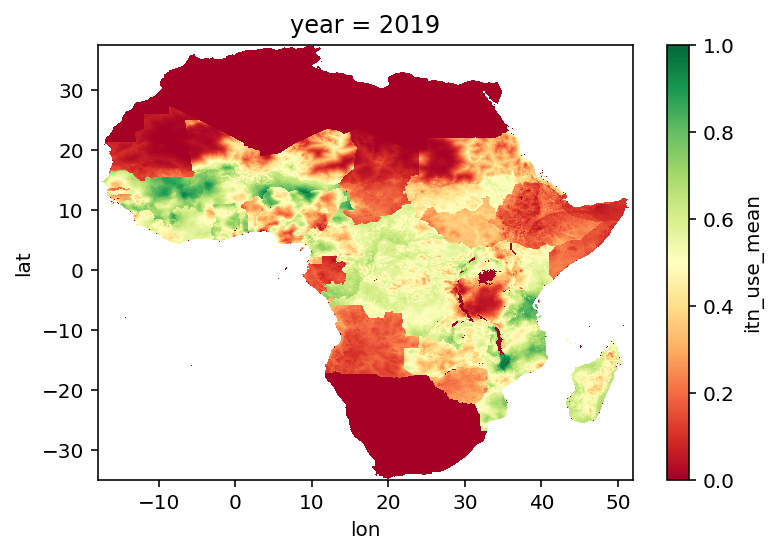

In [10]:
ds_itn.sel(year=2019)["itn_use_mean"].plot(vmin=0, vmax=1, cmap="RdYlGn");

Hopefully this helps to reinforce the idea that data variables like `itn_use_mean` are 3-dimensional arrays, with data values ranging from 0 to 1, and dimensions corresponding to longitude, latitude and year. 

## Accessing variables

Let's now look at how to access variables within a dataset.

### Data variables

To access a data variable, use the square bracket notation, and provide the name of the variable as a string. For example, access the `itn_use_mean` variable.

In [11]:
itn_use_mean = ds_itn["itn_use_mean"]

Note that this syntax is the same as that used for accessing columns within a pandas DataFrame, as we saw in [workshop 2, module 1](../workshop-2/module-1-pandas). There are several parallels between pandas and xarray. You can almost think of xarray as pandas but for multidimensional data.

Let's inspect the type of object that's returned when we access a data variable from an xarray Dataset.

In [12]:
type(itn_use_mean)

xarray.core.dataarray.DataArray

This object is an xarray DataArray. This type of object has many similarities with a numpy array. E.g., it has a number of dimensions:

In [13]:
itn_use_mean.ndim

3

It has a shape:

In [14]:
itn_use_mean.shape

(21, 1741, 1681)

It has a data type:

In [15]:
itn_use_mean.dtype

dtype('float32')

There are also some extra features which a numpy array doesn't have. E.g., the dimensions are named:

In [16]:
itn_use_mean.dims

('year', 'lat', 'lon')

We can also view a representation of this DataArray:

In [17]:
itn_use_mean

<xarray.DataArray 'itn_use_mean' (year: 21, lat: 1741, lon: 1681)>
dask.array<getitem, shape=(21, 1741, 1681), dtype=float32, chunksize=(1, 1741, 1681), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -17.98 -17.94 -17.9 -17.85 ... 51.9 51.94 51.98 52.02
  * lat      (lat) float64 37.52 37.48 37.44 37.4 ... -34.85 -34.9 -34.94 -34.98
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019 2020

We can always convert an xarray DataArray into a numpy array by accessing the `.values` property:

In [18]:
a = itn_use_mean.values

In [19]:
type(a)

numpy.ndarray

Here are some simple statistics computed from the values in the array. Note the array contains some missing data values for the grid squares where the model produces no output, i.e., not on land, so we have to use "NaN-aware" functions:

In [20]:
np.nanmax(a)

0.98126787

In [21]:
np.nanmin(a)

0.0

In [22]:
np.nanmean(a)

0.14171119

In [23]:
np.nanstd(a)

0.2022658

**Exercise 1 (English)**

Access the `itn_access_mean` data variable.

* What type of object is returned?
* Show a representation of the object.
* Convert the object to a numpy array.
* Compute the maximum, minimum, mean and standard deviation.

**Exercice 1 (Français)**

Accéder à la variable de données `itn_mean_access`.

* Quel type d’objet est retourné?
* Afficher une représentation de cet objet.
* Convertir cet objet en un numpy array.
* Calculer le maximum, le minimum, la moyenne (mean) et l’écart type (standard deviation).

### Coordinate variables

Coordinate variables can be accessed in exactly the same way as data variables. E.g., let's access the `lon` coordinate variable:

In [24]:
longitude = ds_itn["lon"]

This also returns an xarray DataArray:

In [25]:
type(longitude)

xarray.core.dataarray.DataArray

Let's look at the representation:

In [26]:
longitude

<xarray.DataArray 'lon' (lon: 1681)>
array([-17.979231, -17.937565, -17.895898, ...,  51.937407,  51.979074,
        52.020741])
Coordinates:
  * lon      (lon) float64 -17.98 -17.94 -17.9 -17.85 ... 51.9 51.94 51.98 52.02

Here we can see some of the coordinate values. E.g., the first column of grid squares corresponds to the longitude value -19.979.

Again we can convert this xarray DataArray into a numpy array if we want to, by using the `.values` property:

In [27]:
longitude.values

array([-17.97923147, -17.93756482, -17.89589817, ...,  51.93740722,
        51.97907388,  52.02074053])

**Exercise 2 (English)**

Access the `year` coordinate variable. 

* What type of object is returned? 
* Show a representation of the object. 
* Convert it to a numpy array.
* Find the maximum and minimum coordinate values.

**Exercice 2 (Français)**

Accéder à la variable de coordonnée `year`.

* Quel type d’objet est retourné?
* Afficher une représentation de cet objet.
* Convertir cet objet en un numpy array.
* Calculer le maximum et le minimum de cette coordonnée.

## Selecting data with indexing

One of the main benefits of xarray is the ability to select data from a particular point or region along one or more dimensions. For example, with our ITN metrics dataset, we could select data from a particular year or range of years we are interested in. This selection is then applied to all variables in a dataset.

There are two main ways to make selections with xarray: positional indexing, and label-based indexing. Let's look at each of these in turn. 

First, let's remind ourselves what the ITN metrics dataset looks like:

In [29]:
ds_itn

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 21)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2000 2001 2002 2003 ... 2018 2019 2020
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

### Positional indexing with `isel()`

Positional indexing means selecting data using the position of the elements within one or more dimensions. This is done using the `.isel()` method on a dataset. 

Note that this is roughly analogous to positional indexing in pandas, using the `.iloc` accessor. However, there are some differences with xarray. In particular, with xarray, we can use the names of the dimensions we want to index.

E.g., the code below selects data from the first year in the dataset, and returns the result as a new dataset:

In [30]:
ds_itn_y0 = ds_itn.isel(year=0)
ds_itn_y0

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
    year                 int64 2000
Data variables:
    itn_access_mean      (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_mean         (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

Note that here, because we selected a single year, the `year` dimension has now disappeared from the dataset, and the data variables now only have the two dimensions of `lat` and `lon`.

We could also select a range of years, e.g., the first two years, by providing a `slice`:

In [31]:
ds_itn_y02 = ds_itn.isel(year=slice(0, 2))
ds_itn_y02

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 2)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2000 2001
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

Note that hear the `year` dimension is retained, but its length is now 2.

**Exercise 3 (English)**

Use positional indexing to select data from the second year, and show a representation of the resulting dataset.

Now select data from the last two years, and show a representation of the resulting dataset.

**Exercice 3 (Français)**

Utiliser un index positionnel pour sélectionner les données de la deuxième année et afficher une représentation du dataset ainsi obtenu.

Sélectionner maintenant les deux dernières années et afficher une représentation du dataset ainsi obtenu.


### Label-based indexing with `sel()`

In general, it is more convenient to make selections using the coordinates themselves. E.g., if we are interested in data from the year 2020, it is easier to ask for that directly. We can do that with xarray by using the `.sel()` method:

In [32]:
ds_itn_2020 = ds_itn.sel(year=2020)
ds_itn_2020

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
    year                 int64 2020
Data variables:
    itn_access_mean      (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_mean         (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

Note again that here we have lost the `year` dimension, because we selected data from a single year.

As we have selected data from 2020, let's now make a rough-and-ready reproduction of [Figure 3](https://www.nature.com/articles/s41467-021-23707-7/figures/3) from [Bertozzi-Villa et al. (2021)](https://doi.org/10.1038/s41467-021-23707-7). Xarray includes some built-in plotting functionality, which we are making use of here by calling the `.plot()` method. The `cmap` parameter provides a colour map to convert the data values into colours. I've chosen [colour maps](https://matplotlib.org/stable/gallery/color/colormap_reference.html) to try and match the original figure from the paper.

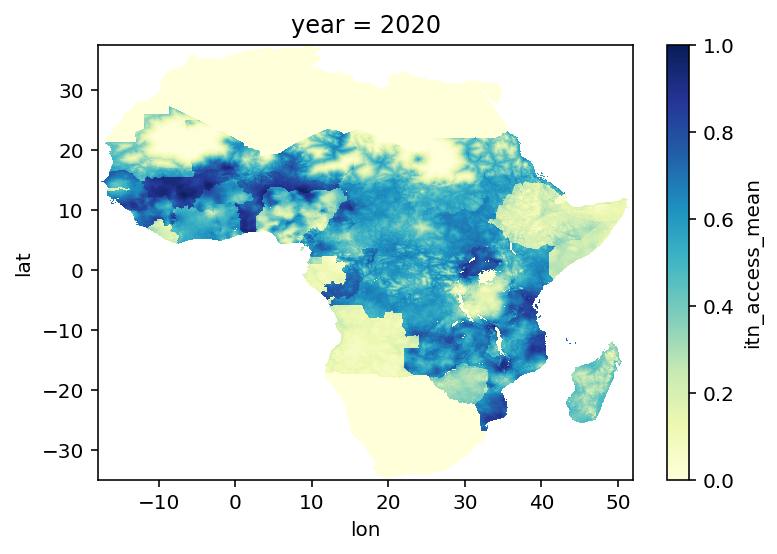

In [33]:
ds_itn_2020["itn_access_mean"].plot(vmin=0, vmax=1, cmap="YlGnBu");

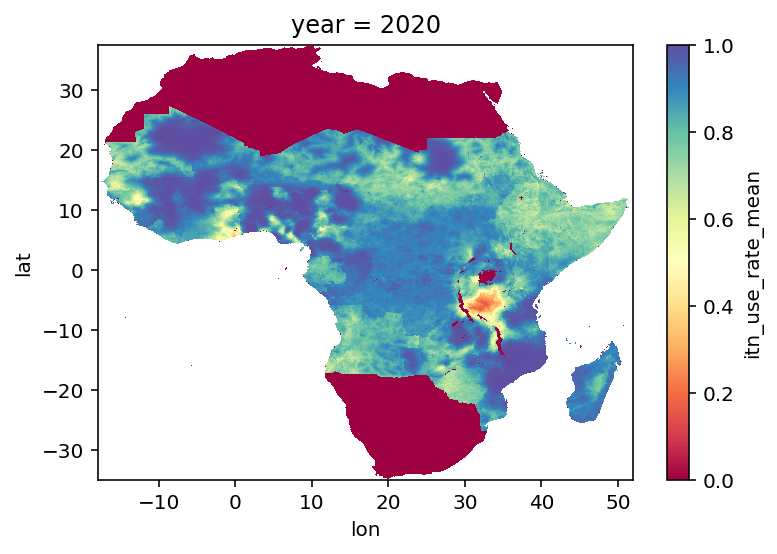

In [34]:
ds_itn_2020["itn_use_rate_mean"].plot(vmin=0, vmax=1, cmap="Spectral");

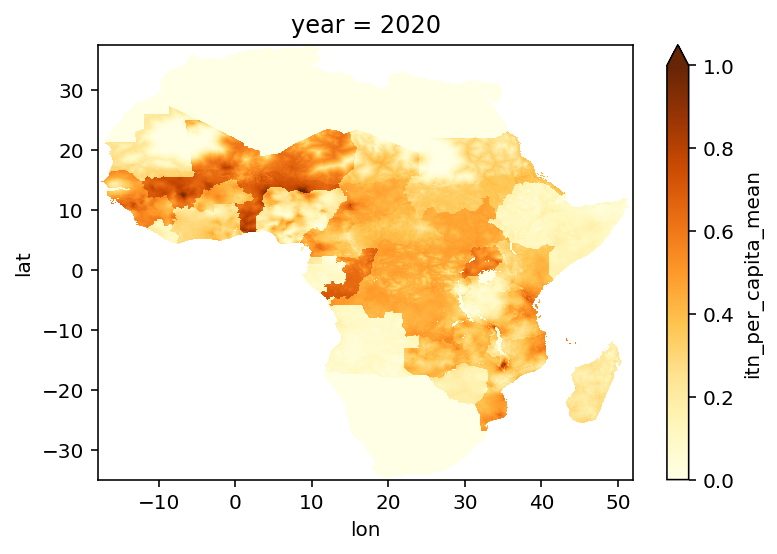

In [35]:
ds_itn_2020["itn_per_capita_mean"].plot(vmin=0, vmax=1, cmap="YlOrBr");

You can also select data for a range of years. E.g., select data from 2018 to 2020.

In [36]:
ds_itn_2018_2020 = ds_itn.sel(year=slice(2018, 2020))
ds_itn_2018_2020

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 3)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2018 2019 2020
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

 Note that here the bounds are included. I.e., we have a dataset with data for 3 years.

**Exercise 4 (English)**

Use label-based indexing to select data for the year 2010, and make a plot of `itn_access_mean`. 

Select data for the years 2000 to 2015, and show a representation of the resulting dataset. How many years are selected?

**Exercice 4 (Français)**

Utiliser un index par étiquette pour sélectionner les données de l’année 2010 et créer un diagramme d’itn_access_mean.

Sélectionner les données pour les années entre 2000 et 2015 et afficher une représentation du dataset ainsi obtenu. Combien d’années ont été sélectionnées?

## Uses of xarray for genomic data

Hopefully the examples above have given you some intuition for what an xarray Dataset is and how to access and select data from within a dataset.

Let's now look at some examples of how we use xarray for genomic data from MalariaGEN.

### SNP calls

We use an xarray Dataset for a set of SNP calls. E.g., access SNP calls for all available samples and for chromosome arm 3R:

In [37]:
ds_snp = ag3.snp_calls(
    region="3R"
)
ds_snp

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4, samples: 3081, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
    sample_id                           (samples) <U24 dask.array<chunksize=(81,), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, samples, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, samples, ploidy) int8 dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
    call_GQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_MQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_AD                             (variants, samples, alleles) int16 dask.array<chunksize=(300000, 50, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, samples, ploidy) bool dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Here the "samples" dimension corresponds to the mosquitoes we have sequenced; the "variants" dimension corresponds to the sites in the reference genome at which we have performed SNP calling; and the "ploidy" dimension reflects the fact that mosquitoes are diploid and so each individual has two genome sequences, one from each parent.

So, here we have SNP calls for 52,226,568 sites in 3,081 diploid samples.

We can use positional indexing to select data for the first sample.

In [39]:
ds_snp.isel(samples=0)

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
    sample_id                           <U24 dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, ploidy) int8 dask.array<chunksize=(300000, 2), meta=np.ndarray>
    call_GQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_MQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_AD                             (variants, alleles) int16 dask.array<chunksize=(300000, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, ploidy) bool dask.array<chunksize=(300000, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Note that the samples dimension is dropped.

We could also access the genotype calls for the first sample, and convert the data into a NumPy array:

In [40]:
gt = ds_snp.isel(samples=0)["call_genotype"].values
gt

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [-1, -1],
       [-1, -1],
       [-1, -1]], dtype=int8)

We can also perform label-based indexing, but to do so we first need to manually set an index. E.g., we can use the "sample_id" coordinate variable to label the "samples" dimension:

In [41]:
ds_snp_ix = ds_snp.set_index(samples="sample_id")
ds_snp_ix

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4, samples: 3081, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
  * samples                             (samples) object 'AR0047-C' ... 'AD04...
Dimensions without coordinates: variants, alleles, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, samples, ploidy) int8 dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
    call_GQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_MQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_AD                             (variants, samples, alleles) int16 dask.array<chunksize=(300000, 50, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, samples, ploidy) bool dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Now we can select data for a given sample by using it's ID, e.g., access the data for sample AR0047-C:

In [42]:
ds_snp_ix.sel(samples="AR0047-C")

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
    samples                             <U8 'AR0047-C'
Dimensions without coordinates: variants, alleles, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, ploidy) int8 dask.array<chunksize=(300000, 2), meta=np.ndarray>
    call_GQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_MQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_AD                             (variants, alleles) int16 dask.array<chunksize=(300000, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, ploidy) bool dask.array<chunksize=(300000, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [43]:
gt = ds_snp_ix.sel(samples="AR0047-C")["call_genotype"].values
gt

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [-1, -1],
       [-1, -1],
       [-1, -1]], dtype=int8)

See [workshop 3, module 3](../workshop-3/module-3-snps) for more information about SNP calls.

### CNV calls

We use an xarray Dataset for a set of CNV calls. E.g., access CNV HMM calls for all available samples and for chromosome arm 3R:

In [44]:
ds_cnv = ag3.cnv_hmm(
    region="3R"
)
ds_cnv

<xarray.Dataset>
Dimensions:                   (variants: 177336, samples: 2886)
Coordinates:
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(177336,), meta=np.ndarray>
    sample_id                 (samples) object dask.array<chunksize=(71,), meta=np.ndarray>
Dimensions without coordinates: variants, samples
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(71,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(71,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Here the "variants" dimension corresponds to the 300 bp genomic windows where copy number has been inferred, and the "samples" dimension corresponds to the individual mosquitoes sequenced. Note that there are 2,886 samples here because not all samples are suitable for CNV calling due to too much variability in coverage over the genome.

As with SNPs, we can use either positional indexing or label-based indexing to select data. E.g., let's access the inferred copy number state data for sample AR0047-C and load the data into a NumPy array:

In [46]:
ds_cnv_ix = ds_cnv.set_index(samples="sample_id")
ds_cnv_ix

<xarray.Dataset>
Dimensions:                   (variants: 177336, samples: 2886)
Coordinates:
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(177336,), meta=np.ndarray>
  * samples                   (samples) object 'AR0047-C' ... 'AD0498-C'
Dimensions without coordinates: variants
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(71,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(71,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [47]:
cn = ds_cnv_ix.sel(samples="AR0047-C")["call_CN"].values
cn

array([ 4,  4,  4, ..., -1, -1, -1], dtype=int8)

For more information about CNV data, see [workshop 2, module 3](../workshop-2/module-3-cnv-calling).

### Allele frequencies

We also use an xarray Dataset to hold data about SNP or CNV allele frequencies, when we need sufficient data to make time series plots or interactive maps. 

E.g., the code below generates an xarray Dataset with CNV frequencies for genes in the Cyp6aa/p gene cluster on chromosome arm 2R, grouping samples by region (admin1_iso) and year: 

In [50]:
cyp6aap_cnv_ds = ag3.gene_cnv_frequencies_advanced(
    region="2R:28,480,000-28,510,000",
    area_by="admin1_iso",
    period_by="year",
    variant_query="max_af > 0.05"
)
cyp6aap_cnv_ds

Load CNV HMM data:   0%|          | 0/504 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/11 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                 (cohorts: 50, variants: 12)
Dimensions without coordinates: cohorts, variants
Data variables: (12/28)
    cohort_area             (cohorts) object 'MW-S' 'TZ-05' ... 'GM-M' 'KE-14'
    cohort_label            (cohorts) object 'MW-S_arab_2015' ... 'KE-14_gcx3...
    cohort_lat_max          (cohorts) float64 -15.93 -1.962 ... 13.57 -3.511
    cohort_lat_mean         (cohorts) float64 -15.93 -1.962 ... 13.57 -3.511
    cohort_lat_min          (cohorts) float64 -15.93 -1.962 ... 13.57 -3.511
    cohort_lon_max          (cohorts) float64 34.76 31.62 34.2 ... -14.92 39.91
    ...                      ...
    variant_gene_name       (variants) object nan 'CYP6AA1' ... 'CYP6AD1'
    variant_gene_strand     (variants) object '+' '-' '-' '-' ... '-' '-' '-'
    variant_label           (variants) object 'AGAP002859 amp' ... 'AGAP00287...
    variant_max_af          (variants) float64 0.1579 0.9355 ... 0.9221 0.9221
    variant_start           (variants) int64 28397312 28480576 ... 28504248
    variant_windows         (variants) int64 397 8 6 7 6 7 7 6 6 6 7 6
Attributes:
    title:    Gene CNV frequencies (2R:28,480,000-28,510,000)

We have a dimension named "cohorts" which corresponds to the groups of mosquitoes within which we have computed frequencies. We also have a dimension named "variants" which here corresponds to gene amplifications and deletions.

Note that this dataset includes variables like "cohort_lat_mean" and "cohort_lon_mean" which allow us to plot frequencies on a map. The actual frequencies for each cohort and variant are stored in the data variable "event_frequency" and the 95% confidence interval is in the data variables "event_frequency_ci_low" and "event_frequency_ci_upp".

Let's plot an interactive map from these data to visualise the frequencies:

In [49]:
ag3.plot_frequencies_interactive_map(
    cyp6aap_cnv_ds,
    title="Gene CNV frequencies, Cyp6aa/p locus"
)

## Well done!

Well done for completing this tutorial, hopefully this was a useful introduction to xarray.

### Exercises

Please now launch this notebook in Google Colab, copy it to your drive, clear the outputs and begin running the cells from the top. As you encounter an exercise, please attempt to complete it.

### Challenge (English)

If you would like an extra challenge, try this. Can you make a line plot that shows how ITN use in Muheza, Tanzania, has changed over time? Here are some hints:

* The geographical coordinates for Muheza are approximately latitude -4.928, longitude 38.749.
* The [xarray .sel() method](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html) accepts an additional `method` parameter. If you provide `method="nearest"` you can select the grid square nearest to your desired coordinates.
* Xarray Datasets have a [.to_dataframe()](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.to_dataframe.html) method which allows you to convert to a pandas DataFrame.
* You could use plotly express to make a line plot of year against ITN use, similar to what we did in [workshop 3, module 1](../workshop-3/module-1-plotly).

### Défi (Français)

Si vous souhaitez un défi supplémentaire, essayez ceci. Pouvez-vous créer un diagramme à lignes qui montre comment l’utilisation des ITN à Muheza en Tanzanie a changé au cours du temps? Voici quelques indices:

* Les coordonnées géographiques de Muheza sont approximativement latitude -4.928 et  longitude 38.749.
* La méthode [xarray .sel()](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html) accepte un paramètre supplémentaire `method`. Si vous utilisez, `method="nearest"`, vous pouvez sélectionner la zone la plus proche des coordonnées que vous voulez.
* Les datasets xarray ont une méthode [.to_dataframe()](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.to_dataframe.html) qui permet de les convertir en DataFrames.
* Vous pouvez utiliser plotly express pour créer un diagramme à lignes des années et de l’utilisation des ITN de la même manière que lors du [Module 1 du Workshop 3](../workshop-3/module-1-plotly).
